In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [15]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [16]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2037
frog_eye_leaf_spot    4139
healthy               4396
powdery_mildew        1210
rust                  1963
scab                  5435
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

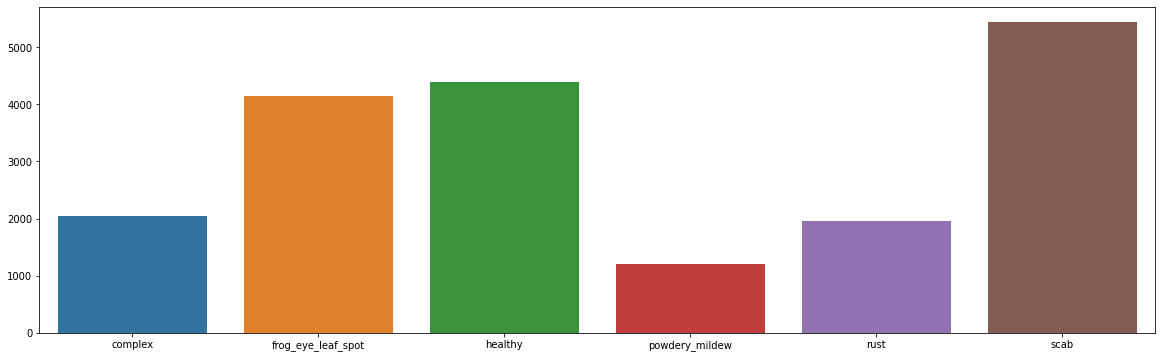

In [17]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

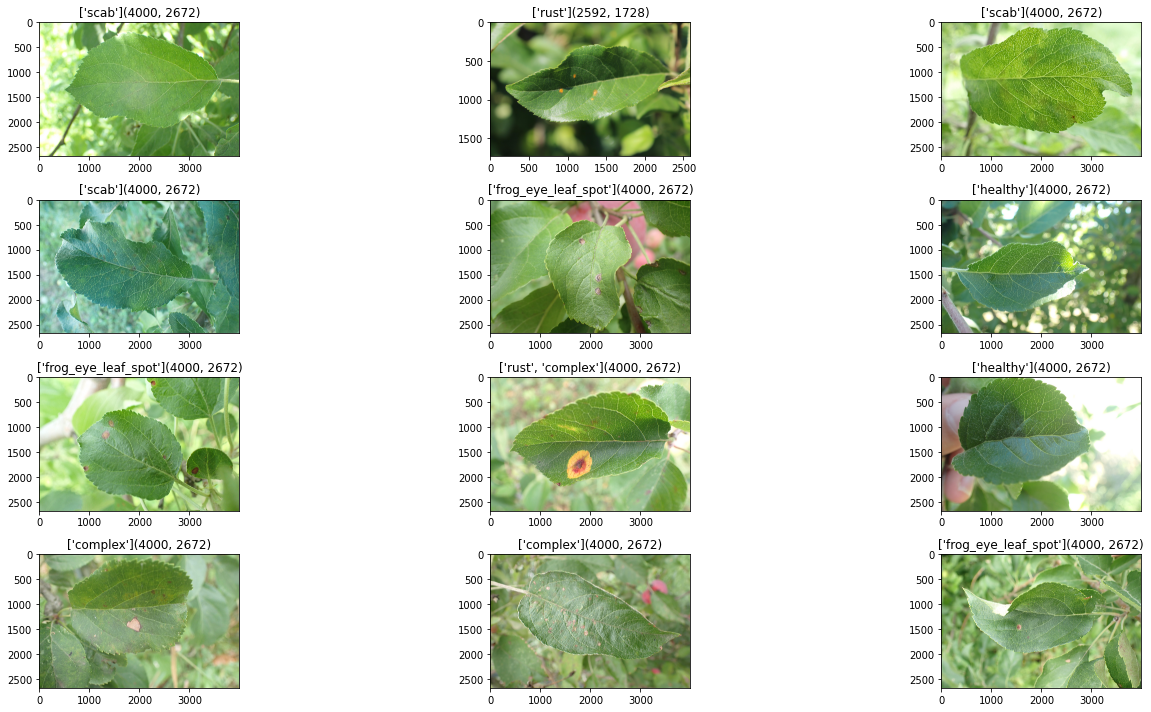

In [18]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [19]:
images = []

for img_name in tqdm(train['image']):
    path = './train_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((224,224))
        img.save(f'./train_images/{img_name}')
    img = cv2.imread(path)
    images.append(img)

100%|██████████| 17701/17701 [28:33<00:00, 10.33it/s]


In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

col_transformer = ColumnTransformer([
    ('multi-hot', MultiHotEncoder(), ['labels'])
])
Y = col_transformer.fit_transform(train)
print(col_transformer.named_transformers_['multi-hot'].categories_)

[array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew',
       'rust', 'scab'], dtype=object)]


In [25]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

print(Y)
images = np.array(images)
images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

[[1 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 ...
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]]
(14160, 224, 224, 3)
(14160, 6)
(3541, 224, 224, 3)
(3541, 6)


In [31]:
seed = 1200
tf.random.set_seed(seed)
TARGET_SIZE = 224
# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = keras.applications.InceptionV3(weights=None,include_top=True,input_shape=(TARGET_SIZE,TARGET_SIZE,3),classes=6, classifier_activation = 'sigmoid')

print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='predictions/Sigmoid:0', description="created by layer 'predictions'")


In [32]:
new_model = tf.keras.Sequential([
    model,
    # keras.layers.GlobalAveragePooling2D(),
    # keras.layers.GlobalMaxPooling2D(),
    # keras.layers.Dropout(0.1), #Changed dropout to 0.1
    # keras.layers.Dense(6, 
    #     kernel_initializer=keras.initializers.RandomUniform(seed=seed),
    #     bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6)                 21815078  
                                                                 
Total params: 21,815,078
Trainable params: 21,780,646
Non-trainable params: 34,432
_________________________________________________________________


In [33]:
## TO use CPU
CUDA_VISIBLE_DEVICES=""
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print('success')

success


In [50]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

Num GPUs Available:  0


KeyboardInterrupt: 

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
# callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=4, mode='max', restore_best_weights=True)
history = new_model.fit(train_x,train_y,epochs=65,verbose=2)


Epoch 1/65
443/443 - 1689s - loss: 0.3539 - accuracy: 0.4839 - f1_score: 0.4687 - 1689s/epoch - 4s/step
Epoch 2/65
443/443 - 1713s - loss: 0.2627 - accuracy: 0.6785 - f1_score: 0.6556 - 1713s/epoch - 4s/step
Epoch 3/65


KeyboardInterrupt: 

## Making predictions

In [ ]:
for img_name in tqdm(test['image']):
    path = './test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./test_size256_images/{img_name}')

100%|██████████| 931/931 [01:25<00:00, 10.95it/s]


In [ ]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (TARGET_SIZE,TARGET_SIZE),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
preds = preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
# threshold = {0: 0.26, # Complex
#              5: 0.61, # scab
#              1: 0.7, # frog eye leaf spot
#              4: 0.5, # rust
#              3: 0.5, # powdery mildew
#              2: 0.3} #healthy

             
threshold = {0: 0.33, # Complex
             5: 0.33, # scab
             1: 0.33, # frog eye leaf spot
             4: 0.33, # rust
             3: 0.33, # powdery mildew
             2: 0.5} # healthy, higher confidence as it is only healthy and no other labels

# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
    
print(indices)

Found 931 validated image filenames.


C:\Users\riley\anaconda3\envs\cv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\riley\anaconda3\envs\cv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[[1], [2], [5], [0, 1], [3, 5], [0, 5], [3], [2], [0, 5], [1], [2], [5], [4], [2], [5], [2], [2], [5], [3], [2], [4], [5], [3], [3], [5], [2], [1], [3, 5], [2], [0, 1, 5], [3], [2], [0, 1], [2], [5], [1], [3], [5], [5], [2], [5], [2], [2], [5], [4], [2], [1], [2], [5], [2], [1], [3], [5], [5], [4], [1], [5], [2], [0], [5], [5], [2], [3], [1], [1, 5], [5], [5], [4], [2], [0, 1], [2], [5], [5], [4], [5], [1], [1], [3], [5], [5], [5], [3], [5], [5], [2], [4], [3, 5], [2], [3], [3], [5], [2], [3], [5], [2], [2], [5], [1], [1], [2], [4], [5], [2], [0, 1], [5], [1], [5], [2], [5], [2], [5], [0, 1], [2], [5], [2], [2], [4], [5], [5], [3], [2], [0, 1, 4], [2], [1], [4], [5], [5], [2], [1], [2], [5], [5], [2], [4], [0, 5], [5], [3, 5], [2], [2], [2], [5], [2], [4], [4], [1, 5], [5], [2], [5], [4], [4], [4], [4], [2], [4], [2], [2], [5], [1], [3], [5], [3], [2], [3], [5], [5], [3], [2], [0, 1, 5], [1], [1], [5], [1], [2], [1], [1], [5], [2], [0, 5], [2], [1], [2], [0, 1], [2], [2], [2], [2], [2]

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['frog_eye_leaf_spot', 'healthy', 'scab', 'complex frog_eye_leaf_spot', 'powdery_mildew scab', 'scab', 'powdery_mildew', 'healthy', 'complex scab', 'frog_eye_leaf_spot', 'healthy', 'scab', 'rust', 'healthy', 'scab', 'healthy', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'rust', 'scab', 'powdery_mildew', 'powdery_mildew', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew scab', 'healthy', 'frog_eye_leaf_spot scab', 'powdery_mildew', 'healthy', 'complex frog_eye_leaf_spot', 'healthy', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'healthy', 'scab', 'healthy', 'healthy', 'scab', 'rust', 'healthy', 'frog_eye_leaf_spot rust', 'healthy', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'rust', 'frog_eye_leaf_spot', 'scab', 'healthy', 'complex', 'scab', 'scab', 'healthy', 'powdery_mildew', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 's

In [ ]:
actuallabels = list(test['labels'])
print(actuallabels)

['frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'powdery_mildew', 'healthy', 'scab', 'complex', 'healthy', 'healthy', 'rust', 'scab', 'complex', 'scab', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'powdery_mildew', 'scab', 'scab', 'frog_eye_leaf_spot', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'healthy', 'complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'healthy', 'scab', 'healthy', 'healthy', 'scab', 'rust', 'healthy', 'rust', 'powdery_mildew', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'rust', 'rust', 'complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'complex', 'scab', 'scab', 'healthy', 'healthy', 'frog_eye_leaf_spot', 'complex', 'scab', 'complex', 'rust', 'healthy', 'complex', 'healthy', 'complex', 'scab', 'rust', 'scab', 'complex', 'frog_eye_leaf_spot', 'scab', 'scab', 'scab', 'powdery_mildew',

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.6842105263157895


In [ ]:
actual_test = pd.read_csv('sample_submission.csv')

In [ ]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (TARGET_SIZE,TARGET_SIZE),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = new_model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()
# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

Found 3 validated image filenames.


C:\Users\riley\anaconda3\envs\cv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\riley\anaconda3\envs\cv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[[0.4616661  0.06672823 0.00652874 0.02521774 0.16362885 0.1408652 ]
 [0.44353762 0.22414887 0.0018529  0.00463054 0.01260194 0.8988457 ]
 [0.20455542 0.33576888 0.05441493 0.01574841 0.31272215 0.13546184]]
[[0], [0, 5], [1]]


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['complex', 'complex scab', 'frog_eye_leaf_spot']


In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,complex
1,ad8770db05586b59.jpg,complex scab
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
